In [ ]:
!pip install torch torchvision matplotlib pillow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


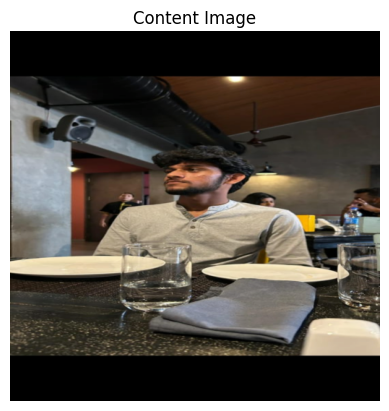

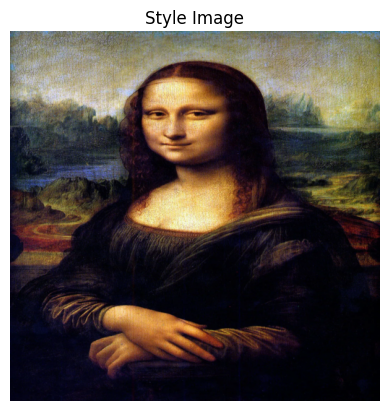

In [ ]:
def load_image(image_name):
    image = Image.open(image_name).convert("RGB")
    # Ensure images have same dimensions for easier processing
    # You can adjust size or crop strategies based on your images
    # For simplicity, let's resize to a common dimension
    loader = transforms.Compose([
        transforms.Resize((512, 512)), # Resize to a standard size
        transforms.ToTensor(), # Convert to PyTorch tensor (0-1 range)
        # Normalization specific to pre-trained ImageNet models
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = loader(image).unsqueeze(0) # Add batch dimension (1, C, H, W)
    return image.to(device)

# Load your images
content_img = load_image("content.jpg")
style_img = load_image("style.webp")

# Function to show images (for debugging/visualization)
def show_image(tensor, title=None):
    # Denormalize for display
    unloader = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    image = unloader(tensor.cpu().clone().squeeze(0))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display loaded images
show_image(content_img, "Content Image")
show_image(style_img, "Style Image")

In [ ]:
# Load VGG-19, set it to evaluation mode, and move to GPU
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# We don't need to train VGG itself, so freeze its parameters
for param in vgg.parameters():
    param.requires_grad = False

# Define the layers we want to extract features from
# These are empirically chosen for good results
content_layers = ['conv4_2'] # Layer for content representation
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'] # Layers for style representation

# Build a custom VGG model that only returns the features from desired layers
class VGGFeatureExtractor(nn.Module):
    def __init__(self, vgg, style_layers, content_layers):
        super(VGGFeatureExtractor, self).__init__()
        self.vgg = vgg
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.all_layers = sorted(list(set(style_layers + content_layers)), key=lambda x: int(x.split('_')[0][4:]))

        self.net = nn.Sequential()
        layer_names = []
        i = 0
        for layer in vgg:
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv{}_{}'.format(i, layer.kernel_size[0]) # approximated, VGG original layers
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(i, layer.kernel_size[0] if hasattr(layer, 'kernel_size') else '')
                layer = nn.ReLU(inplace=False) # Important for style transfer to not modify directly
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn{}_{}'.format(i, layer.kernel_size[0] if hasattr(layer, 'kernel_size') else '')
            else:
                continue # Skip other layers like AvgPool, Linear

            self.net.add_module(name, layer)
            layer_names.append(name)
            # Stop if we've added all necessary layers
            if name == self.all_layers[-1]:
                break

        # Adjust layer names if VGG from torchvision uses different indexing
        # This is a common point of confusion. Let's use actual layer indices
        # and map to conceptual names.
        # A more robust way: iterate through actual vgg.children()
        # and map to indices. For simplicity, we'll use a direct index mapping.
        # Let's rebuild the feature extractor more cleanly using children()

        self.content_feature_extractor = nn.Sequential()
        self.style_feature_extractor = nn.Sequential()
        model_layer_names = [] # To store the names of actual modules
        current_layer = 0

        # This is a bit manual, but precise for VGG-19 features.
        # Content: conv4_2 (layer 22 in VGG-19 features list)
        # Style: conv1_1 (1), conv2_1 (6), conv3_1 (11), conv4_1 (20), conv5_1 (29)
        # These are indices within the `vgg` Sequential model (vgg.children())
        content_vgg_idx = 22 # Corresponding to conv4_2
        style_vgg_indices = [1, 6, 11, 20, 29] # Corresponding to conv1_1, conv2_1, etc.

        self.selected_content_layers = [vgg[i] for i in range(content_vgg_idx + 1)] # up to and including conv4_2
        self.selected_style_layers = [vgg[i] for i in range(max(style_vgg_indices) + 1)] # up to and including conv5_1

    def forward(self, x):
        content_features = []
        style_features = []
        # We'll run the full VGG and collect features at specific conceptual layers
        # This is simpler than creating a custom sequential.

        # Map conceptual names to actual layers after running vgg:
        # Let's simplify and just pass through VGG and extract.
        # This class is not needed if we iterate through VGG directly.

        # Simpler approach:
        features = []
        layer_count = 0
        for layer in self.vgg:
            x = layer(x)
            if isinstance(layer, nn.ReLU): # After ReLU, the convolution features are often captured
                layer_count += 1
                if f'conv{layer_count}_1' in self.style_layers or f'conv{layer_count}_2' in self.content_layers: # Simplified check
                    features.append(x)
        return features


# Let's simplify the feature extraction without a custom class for now.
# We will manually iterate through the VGG layers in the loss calculation.

In [ ]:
# Function to calculate Gram Matrix
def gram_matrix(input_tensor):
    batch_size, channels, height, width = input_tensor.size()
    features = input_tensor.view(batch_size * channels, height * width) # Reshape to (C, H*W)
    G = torch.mm(features, features.t()) # Compute Gram product
    # Normalize by the number of elements in each feature map
    return G.div(batch_size * channels * height * width)

# The content loss is simply MSE
content_criterion = nn.MSELoss()

# We will combine this into the main training loop

In [ ]:
# Initialize the generated image with the content image
# We make it a 'learnable' parameter
generated_img = content_img.clone().requires_grad_(True).to(device)

# Optimizer for the generated image
# LBFGS often yields slightly better results but Adam is easier to set up
# For simplicity, let's start with Adam
optimizer = optim.Adam([generated_img], lr=0.01)

# Weights for content and style losses
style_weight = 1e6  # Adjust these to balance style vs. content
content_weight = 1e1

num_steps = 6000 # Number of iterations
display_step = 500 # Display every X steps

# Layers from VGG-19 features (adjust based on actual VGG structure)
# These are conceptual names, we'll map them to actual layer outputs in the loop
vgg_layers = {
    '0': 'conv1_1',   # 0
    '5': 'conv2_1',   # 5
    '10': 'conv3_1',  # 10
    '19': 'conv4_1',  # 19 (for style)
    '21': 'conv4_2',  # 21 (for content)
    '28': 'conv5_1',  # 28
}

def get_features(image, model, layers):
    features = {}
    x = image
    # Iterate through the model's children to get layer outputs
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Get initial content and style features from the VGG model
content_features = get_features(content_img, vgg, vgg_layers)
style_features = get_features(style_img, vgg, vgg_layers)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}


print("Starting Style Transfer Training...")
for step in range(num_steps):
    optimizer.zero_grad()

    # Get features for the generated image
    generated_features = get_features(generated_img, vgg, vgg_layers)

    # Calculate Content Loss
    current_content_features = generated_features[content_layers[0]] # conv4_2
    original_content_features = content_features[content_layers[0]]
    content_loss = content_criterion(current_content_features, original_content_features)

    # Calculate Style Loss
    style_loss = 0
    for layer in style_layers:
        current_style_features = generated_features[layer]
        current_gram = gram_matrix(current_style_features)
        original_gram = style_grams[layer]
        style_loss += content_criterion(current_gram, original_gram) # MSE for Grams

    # Total Loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Display progress
    if (step + 1) % display_step == 0:
        print(f"Step [{step+1}/{num_steps}], Total Loss: {total_loss.item():.4f}, Content Loss: {content_loss.item():.4f}, Style Loss: {style_loss.item():.4f}")
        # Save and show the generated image periodically
        save_image(generated_img, f"generated_img_{step+1}.png")
        # show_image(generated_img, f"Generated Image at Step {step+1}") # Uncomment to display in Colab during training

Starting Style Transfer Training...
Step [500/6000], Total Loss: 6.1206, Content Loss: 0.2029, Style Loss: 0.0000
Step [1000/6000], Total Loss: 5.8504, Content Loss: 0.2027, Style Loss: 0.0000
Step [1500/6000], Total Loss: 5.7027, Content Loss: 0.2041, Style Loss: 0.0000
Step [2000/6000], Total Loss: 5.6169, Content Loss: 0.2029, Style Loss: 0.0000
Step [2500/6000], Total Loss: 5.5469, Content Loss: 0.2039, Style Loss: 0.0000
Step [3000/6000], Total Loss: 5.5091, Content Loss: 0.2045, Style Loss: 0.0000
Step [3500/6000], Total Loss: 5.4947, Content Loss: 0.2023, Style Loss: 0.0000
Step [4000/6000], Total Loss: 5.4939, Content Loss: 0.2034, Style Loss: 0.0000
Step [4500/6000], Total Loss: 5.4322, Content Loss: 0.2018, Style Loss: 0.0000
Step [5000/6000], Total Loss: 5.6079, Content Loss: 0.2158, Style Loss: 0.0000
Step [5500/6000], Total Loss: 5.3918, Content Loss: 0.2021, Style Loss: 0.0000
Step [6000/6000], Total Loss: 5.3768, Content Loss: 0.1987, Style Loss: 0.0000



Training Complete!


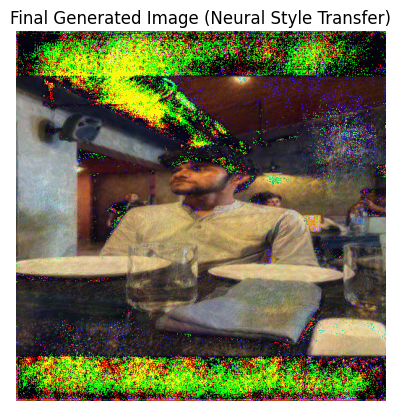

In [ ]:
print("\nTraining Complete!")
show_image(generated_img, "Final Generated Image (Neural Style Transfer)")
save_image(generated_img, "final_stylized_image.png")